# Validação Cruzada: Avaliando a performance dos estimadores

Treinar um modelo de aprendizagem e testá-lo nos mesmos dados é um erro metodológico: pode gerar um modelo capaz de repetir perfeitamente os rótulos das amostras já conhecidas mas que falha ao predizer o valor de novos dados desconhecidos. Esse problema, como já vimos, é chamado de overfitting. Uma prática comum para evitá-lo é manter uma parte dos dados disponíveis como conjunto de teste. Abaixo temos um fluxograma típico do fluxo de treinamento com validação cruzada (_cross validation_ ). Os melhores parâmetros podem ser encontrados utilizando técnicas de busca em grade, busca aleatória ou otimização meta-heurística.

<img src='assets/grid_search_workflow.png' width=500px>

No Scikit-Learn, podemos separar rápidamente nosso conjunto de dados em treino e teste com a já conhecida função `train_test_split`. Vamos carregar o dataset iris e treinar o SVM nele.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

Agora podemos separar o conjunto de dados usando 60% para treinamento e 40% para teste (avaliação) do nosso classificador:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

print('X_train.shape, y_train.shape = ', X_train.shape, y_train.shape)

print('X_test.shape, y_test.shape = ', X_test.shape, y_test.shape)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

X_train.shape, y_train.shape =  (90, 4) (90,)
X_test.shape, y_test.shape =  (60, 4) (60,)


0.9666666666666667

Quando avaliamos diferentes configurações de hyperparâmetros, como por exemplo o $C$ no SVM, ainda existe o risco de _overfitting_ no conjunto de testes por que o valor pode ser ajustado até que o resultado seja ótimizado. Assim, o conhecimento sobre os dados de teste podem "vazar" para o modelo e as métricas de avaliação deixam de reportar a performance real do modelo num cenário generalizado (com amostras desconhecidas). Para resolver esse problema, outra parte do _dataset_ pode ser mantida, chamada de "conjunto de validação": treinamento é feito no conjunto de treinamento, na sequencia o conjunto de validação é usado para avaliar o modelo, e após finalizar o treinamento, a avaliação do modelo em um cenário desconhecido é feita usando o conjunto de testes. 

No entanto, ao particionar os dados disponíveis em 3 conjuntos, reduzimos drasticamente o número de amostras que podem ser usadas para treinar o modelo, e os resultados podem depender de uma escolha aleatória particular do par de conjuntos (treinamento, validação).

A solução para esse problema é a validação cruzada (CV). Um conjunto de teste continua sendo separado para a avaliação final, mas o conjunto de validação não é mais necessário. Na abordagem mais básica, chamada $k$-fold CV, o conjunto de treinamento é dividido $k$ conjuntos menores (outras abordagens seguem os mesmos princípios). O procedimento a seguir é executado para cada um dos $k$ "folds":

- O modelo é treinado usando $k-1$ _folds_ como dados de treinamento;

- O modelo resultante é validado nos dados restantes, i.e., esses dados são usados como teste para computar a performance do modelo;

A média das métricas reportadas pelo $k$-fold CV é computada. Essa abordagem é cara em termos computacionais, mas não desperdiça dados como quando separamos um conjunto de validação, sendo essa sua maior vantagem quando consideramos _datasets_ pequenos.

<img src='assets/grid_search_cross_validation.png' width=500px>


### Computando métricas com validação cruzada

O modo mais fácil de se computar o resultado da validação cruzada é usando a função `cross_val_score`, passando como parâmetro o estimador e o dataset.

O exemplo a seguir demonstra como estimar a acurácia do SVM sobre o dataset _iris_ dividindo os dados, ajustando o modelo e computando os pontos 5 vezes consecutivas, com diferentes divisões do conjunto de treinamento a cada execução:

In [9]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)

# computa diretamente os valores as métricas de saída para cada execução da validação cruzada
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

O valor médio e o desvio padrão podem ser computado:

In [6]:
print("%0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean(), scores.std()))

0.98 de acurácia com desvio padrão de 0.02


O valor computado a cada iteração do CV é a métrica padrão do estimador. É possível trocá-la usando o parâmetro scoring: 

In [11]:
from sklearn import metrics

scores = cross_val_score(
    clf, X, y, cv=5, scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

Outras métricas disponíveis podem ser encontradas [aqui](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). No caso do _dataset_ iris, o número de amostras por classe é balanceado, então o F1-score e a acurácia são quase iguais.

Quando o argumento cv é um inteiro `cross_val_score` usa as estratégias [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) ou [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), dependendo do caso.

Também é possível usar outras estratégias de validação cruzada passando um iterador, como, por exemplo:

In [12]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]

# gera os 5 splits
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ])

### Validação cruzada com transformação dos dados 

Assim como testar nosso modelo em dados não usados durante o treinamento, pré-processamento (como normalização, selecão de característica, etc.) e outras transformações similares devem ser executadas no conjunto de treinamento e aplicadas no conjunto de teste para predição:


In [13]:
from sklearn import preprocessing

# divide os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

# cria um pré-processador para normalizar os dados
scaler = preprocessing.StandardScaler().fit(X_train)

# transforma os dados de treinamento
X_train_transformed = scaler.transform(X_train)

# treina o modelo
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)

# transforma os dados de teste
X_test_transformed = scaler.transform(X_test)

# computa o resultado
clf.score(X_test_transformed, y_test)

0.9333333333333333

Usando o método [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) deixa mais fácil organizar o processo, executando o comando com a validação cruzada:

In [14]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.93333333, 0.95555556, 0.93333333, 0.97777778])

### A função `cross_validate` e a avaliação de múltiplas métricas

A função `cross_validate` se diferencia da função `cross_val_score` de 2 maneiras:

- ela permite especificar multiplas métricas para avaliação.

- ela retorna um dicionário contendo as métricas `fit-times`, `score-times` (e opcionalmente os resultados do treinamento e o modelo treinado), além dos resultados sobre o conjunto de testes.

Para avaliar uma única métrica, onde o parâmetro scoring é uma _string_, _callable_ ou _None_, as chaves do dicionário serão `['test_score', 'fit_time', 'score_time']`.

Para avaliar múltiplas métricas, o valor retornado é um dicionário com as seguintes chaves: `['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']`

`return_train_score` é setado para `False` por padrão para economizar tempo de processamento. para avaliar o resultados sobre o conjunto de treinamento é necessário setar esse valor para `True`.

Você também pode armazenar os modelos treinados setando `return_estimator=True`.

As múltiplas métricas podem ser especificadas tanto como uma lista, tupla, ou conjunto de nomes de marcadores:

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

# métricas a serem computadas
scoring = ['precision_macro', 'recall_macro']

# definindo o modelo
clf = svm.SVC(kernel='linear', C=1, random_state=0)

# treinando o modelo com validação cruzada - Usando strings no scoring
scores = cross_validate(clf, X, y, scoring=scoring)
# imprimindo as chaves
print(sorted(scores.keys()))

scores['test_precision_macro']

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']


array([0.96969697, 1.        , 0.96969697, 0.96969697, 1.        ])

Ou como um dicionário mapeando os marcadores para uma função:

In [17]:
from sklearn.metrics import make_scorer

# monta o conjunto de métricas a ser retornado usando strings ('precision_macro') e callable (make_scorer)
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}

# treinando o modelo com validação cruzada - return_train_score=True para retornar os resultados sobre 
#    o conjunto de treinamento
scores = cross_validate(clf, X, y, scoring=scoring,
                        cv=5, return_train_score=True)
print(sorted(scores.keys()))

scores['train_rec_macro']

['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro', 'train_prec_macro', 'train_rec_macro']


array([0.975     , 0.975     , 0.99166667, 0.98333333, 0.98333333])

Exemplo de validação cruzada usando uma única métrica:

In [18]:
# passando return_estimator=True para retornar o modelo treinado
scores = cross_validate(clf, X, y,
                        scoring='precision_macro', cv=5,
                        return_estimator=True)
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

### Obtendo os rótulos estimados com validação cruzada

A função [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) tem uma interface similar à `cross_val_score`, mas retorna os rótulos para cada amostra no momento em que foi classificada. O método não é indicado pois as amostras são agrupadas de forma aleatória e essa classificação dependerá do agrupamento.

Todo caso, ainda pode ser útil em 2 situações:
1. visualização dos dados obtidos de diferentes modelos
2. mistura de modelos, utilizado, por exemplo, em _ensamble_ de métodos (quando utilizamos a votação entre vários classificadores para encontrar o melhor resultado).


## Iteradores de validação cruzada

### Validação cruzada em dados independentes e distribuídos de forma idêntica

Assumir que os dados são independentes e distribuídos de forma idêntica (i.i.d.) é assumir que todas as amostras foram gerados a partir do mesmo processo de distribuição.

Para isso, podemos usar o famoso $k$-fold:

### $K$-fold

[KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) divide todas as amostras em grupos de amostras, chamados de _folds_ (se $k=n$, o modelo é equivalente à estratégia Leave One Out), de tamanhos iguais (se possível). O modelo é aprendido usando $k-1$ _folds_ e o _fold_ restante é usado pra teste.

Exemplo de validação cruzada 2-_fold_ em um _dataset_ com 4 amostras:

In [19]:
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d"]
kf = KFold(n_splits=2)
for i, (train, test) in enumerate(kf.split(X)):
    # printa os indices dos conjuntos de treinamento e teste
    print("Fold %s - Treinamento: %s Teste: %s" % (i+1, train, test))

Fold 1 - Treinamento: [2 3] Teste: [0 1]
Fold 2 - Treinamento: [0 1] Teste: [2 3]


Na figura abaixo podemos visualizar o comportamento da validação cruzada. note que o $K$-_fold_ não é leva em consideração as classes ou agrupamento das amostras.

<img src='assets/kfold.png' width=500px>

Cada _fold_ é constituido por 2 arrays: o primeiro está relacionado ao conjunto de treinamento e o segundo ao conjunto de teste. Sendo assim, poderiamos criar os conjuntos de treino/teste com os indices:

In [20]:
X = np.array([[0., 0.], [1., 1.], [-1., -1.], [2., 2.]])
y = np.array([0, 1, 0, 1])
X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

# considerando os indices treino [0 1] e teste [2 3] acima, temos
print('X_train = \n', X_train)
print('X_test = \n', X_test)
print('y_train = ', y_train)
print('y_test = ', y_test)

X_train = 
 [[0. 0.]
 [1. 1.]]
X_test = 
 [[-1. -1.]
 [ 2.  2.]]
y_train =  [0 1]
y_test =  [0 1]


### Outros métodos para dados independentes e distribuídos de forma idêntica

- [RepeatedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold) - repete $k$-_folds_ $n$ vezes
- [Leave One Out (LOO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) - similar ao $k$-_folds_ com $k=$ ao número de amostras
- [Leave P Out (LPO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html#sklearn.model_selection.LeavePOut) - similar ao LOO, deixando $p$ amostras fora do processo. Nesse caso pode haver sobreposição de amostras.
- [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) - gera um número independente de divisões de treinamento/teste definida pelo usuário. 

## Validação cruzada com estratificação baseada nos rótulos 


Alguns problemas de classificação apresentam uma distribuição de classes altamente desbalanceadas. Nesses casos, é recomendado usar [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), que assegura a frequência e tenta preservar, aproximadamente, a distribuição das classes em cada divisão dos conjuntos de treinamento e teste.

### Stratified k-fold

[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) é uma variação do $k$-fold que retorna os _folds_ estratificados: cada conjunto contém aproximadamente a mesma proporção de amostras de cada classe que o _dataset_ completo.

Aqui temos um exemplo de validação cruzada 3-_fold_ estratificada em um conjunto de dados com $50$ amostras com 2 classes desbalanceadas. Mostraremos o número de amostras de cada classe e compararemos com o $k$-_fold_.

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
# gerando 50 amostras
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
print(X[:,0], y)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [22]:
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]


In [23]:
kf = KFold(n_splits=3)
for train, test in kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [28  5]   |   test -  [17]
train -  [28  5]   |   test -  [17]
train -  [34]   |   test -  [11  5]


Podemos observar que `StratifiedKFold` preserva a razão das classes (aproximadamente 1/10) tanto para os conjuntos de treinamento quanto de teste.

A figura abaixo ilustra esse comportamento:

<img src='assets/stractkfold.png' width=500px>

# Otimizando os hyper-parâmetros de um modelo

Hyper-parâmetros são parametros que não são aprendidos diretamente pelo modelo, e geralmente precisam ser escolhidos pelo usuário. Alguns exemplos típicos são o $C$ e o kernel do SVM, e o learning rate das redes neurais.

Uma prática recomendada é percorrer o espaço de busca desses hyper-parâmetros a fim de encontrar o melhor resultado utilizando a validação cruzada.

O Scikit-Learn oferece duas opções genéricas para encontrar esses valores: [GridSearchCV ](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), que faz uma busca exaustiva considerando todas as possíveis combinações de parametros, e [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV), que seleciona um determinado número de combinações candidatas do espaço de busca usando uma distribuição específica. Ambas possuem uma contrapartida mais eficiente que vai reduzindo as opções pela metade, i.e., [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV) e [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV).

## Grid Search exaustivo

Faz uma busca exaustiva por todas as possíveis combinações de parâmetros

In [24]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Carrega o dataset digits
digits = datasets.load_digits()

# converte as imagens de matrizes (2D) para vetores 1D
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# divide o conjunto em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Seta os possíveis parâmetros
#   Note que quando usamos kernel RBF também precisamos otimizar o parâmetro gamma
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# métricas
scores = ['precision', 'recall']

for score in scores:
    print("# Otimizando os hyper-parameters para %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Melhor conjunto de parâmetros encontrados durante treinamento com validação cruzada:")
    print()
    print(clf.best_params_)
    print()
    print("Resultado da validação cruzada para cada combinação da grade:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Relatório de classificação detalhado:")
    print()
    print("O modelo é treinado sobre todo o conjunto de treinamento.")
    print("As métricas são computadas apenas considerando o conjunto de testes.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Otimizando os hyper-parameters para precision

Melhor conjunto de parâmetros encontrados durante treinamento com validação cruzada:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Resultado da validação cruzada para cada combinação da grade:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Relatório de classificação deta

## Busca aleatória

Enquanto o grid search busca exaustivamente o melhor resultado testando todas as possíveis combinações de valores, `RandomizedSearchCV` implementa uma busca aleatória, sorteando $n$ possíveis valores dentro de uma distribuição. Essa abordagem possui 2 vantagens em relação ao _grid search_:


- O custo computacional pode ser definido independentemente do número de parâmetros e possíveis combinações (escolhe de ante-mão quantas vezes a busca será executada).

- Adicionar parâmetros que não influenciam na performance do modelo não vão influenciar no tempo de busca (mais parâmetros não implica em maior número de execuções).

In [26]:
import numpy as np

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier

# baixando o dataset
X, y = load_digits(return_X_y=True)

# construindo um classificador
clf = SGDClassifier(loss='hinge', penalty='elasticnet',
                    fit_intercept=True)


# função para processar o resultado
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Modelo com rank: {0}".format(i))
            print("Media sobre conjunto de validação: {0:.3f} (desvio: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parâmetros: {0}".format(results['params'][candidate]))
            print("")


# especificando os parâmetros e distribuições
param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}

# executando a busca aleatória
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV levou %.2f segundos para %d combinações"
      " candidatas." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# usando o grid search completo
param_grid = {'average': [True, False],
              'l1_ratio': np.linspace(0, 1, num=10),
              'alpha': np.power(10, np.arange(-4, 1, dtype=float))}

# executando o grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV levou %.2f segundos para %d combinações candidatas"
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV levou 26.82 segundos para 20 combinações candidatas.
Modelo com rank: 1
Media sobre conjunto de validação: 0.922 (desvio: 0.034)
Parâmetros: {'alpha': 0.0001967058442685228, 'average': True, 'l1_ratio': 0.5661154074913664}

Modelo com rank: 2
Media sobre conjunto de validação: 0.921 (desvio: 0.033)
Parâmetros: {'alpha': 0.000877642574424711, 'average': True, 'l1_ratio': 0.3322874249015114}

Modelo com rank: 3
Media sobre conjunto de validação: 0.919 (desvio: 0.031)
Parâmetros: {'alpha': 0.00046103109710893275, 'average': True, 'l1_ratio': 0.899911226269865}



/home/leandro/miniconda3/envs/torchEnv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/leandro/miniconda3/envs/torchEnv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/leandro/miniconda3/envs/torchEnv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/leandro/miniconda3/envs/torchEnv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increa

GridSearchCV levou 156.55 segundos para 100 combinações candidatas
Modelo com rank: 1
Media sobre conjunto de validação: 0.931 (desvio: 0.029)
Parâmetros: {'alpha': 0.001, 'average': True, 'l1_ratio': 0.1111111111111111}

Modelo com rank: 2
Media sobre conjunto de validação: 0.929 (desvio: 0.031)
Parâmetros: {'alpha': 0.0001, 'average': True, 'l1_ratio': 0.5555555555555556}

Modelo com rank: 3
Media sobre conjunto de validação: 0.928 (desvio: 0.034)
Parâmetros: {'alpha': 1.0, 'average': False, 'l1_ratio': 0.0}



## Procurando os melhores parâmetros por divisões sucessivas

O método por divisões sucessivas ( _successive halving (SH)_ ) funciona como um torneio entre as combinações de parâmetros. É um método iterative em que todos as combinações candidatas são avaliadas com uma pequena quantidade de recursos na primeira iteração. Apenas alguns candidatos são selecionados para a próxima iteração, na qual será alocada uma quantidade maior de recursos. Para otimização de hyper-parâmetros, esse recurso representa o número de amostras de treinamento.

Como ilustrado na figura abaixo, apenas um sub-conjunto de candidatos "sobrevivem" até a última iteração. Estes são os candidates que conseguiram resultados consistentes entre os melhores por todas as iterações. A cada iteração, uma quantidade maior de amostras é alocada por candidato.


<img src='assets/halving.png' width=500px>

### Comparando Grid Search com Divisões Sucessivas

Este exemplo compara a otimização dos hyper-parâmetros do SVM usando `HalvingGridSearchCV` e `GridSearchCV`.

In [27]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

Primeiramente definimos o espaço de busca para os hyper-parâmetros do SVM, e computamos o tempo necessário para treinar usando `HalvingGridSearchCV` e `GridSearchCV`.

In [28]:
rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {'gamma': gammas, 'C': Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(estimator=clf, param_grid=param_grid, factor=2,
                          random_state=rng)
gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

Agora plotamos os mapas de calor para cada método de otização.

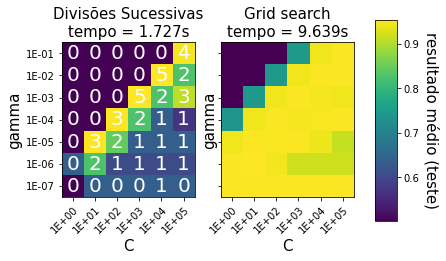

In [29]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    results = pd.DataFrame.from_dict(gs.cv_results_)
    results['params_str'] = results.params.apply(str)
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values('iter').pivot_table(
                index='param_gamma', columns='param_C',
                values='mean_test_score', aggfunc='last'
        )
    else:
        scores_matrix = results.pivot(index='param_gamma', columns='param_C',
                                      values='mean_test_score')

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(['{:.0E}'.format(x) for x in Cs])
    ax.set_xlabel('C', fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(['{:.0E}'.format(x) for x in gammas])
    ax.set_ylabel('gamma', fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(index='param_gamma',
                                         columns='param_C', values='iter',
                                         aggfunc='max').values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(j, i, iterations[i, j],
                        ha="center", va="center", color="w", fontsize=20)

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('resultado médio (teste)', rotation=-90, va="bottom",
                           fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title('Divisões Sucessivas\ntempo = {:.3f}s'.format(gsh_time),
              fontsize=15)
ax2.set_title('Grid search\ntempo = {:.3f}s'.format(gs_time), fontsize=15)

plt.show()